In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
import glob 
import random
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression


def arctic_average(data_array, lats):
    """
    Find monthly average arctic TAS timeseries.
    """
    weights = np.cos(np.deg2rad(lats))
    weighted_data_array = np.multiply(data_array, weights[np.newaxis, :, np.newaxis])
    denom = np.nansum(weights)*144 # there are 144 longitudinal grid points
    shape = np.shape(weighted_data_array)
    weighted_data_reshaped = np.reshape(weighted_data_array, (shape[0], shape[1]*shape[2]))
    weighted_sum = np.nansum(weighted_data_reshaped, axis=1)
    weighted_average = np.divide(weighted_sum, denom)
    return(weighted_average)


def ndjfm_field_mean(data_field):
    """
    This function finds the mean over NDJFM data just for fields.
    """
    data_cal = np.reshape(data_field, (int(len(data_field)/12), 12, 72, 144))
    data_cal_ndjfm = np.swapaxes([data_cal[:,0], data_cal[:,1], data_cal[:,2], 
                                  data_cal[:,10], data_cal[:,11]], 0,1)
    cal_shape = np.shape(data_cal_ndjfm)
    data_ts_ndjfm = np.reshape(data_cal_ndjfm, (cal_shape[0]*cal_shape[1], cal_shape[2], cal_shape[3]))[3:-2]
    data_cal_ndjfm_organized = np.reshape(data_ts_ndjfm, (int(len(data_ts_ndjfm)/5), 5, cal_shape[2], cal_shape[3]))
    data_ndjfm_mean = np.nanmean(data_cal_ndjfm_organized, axis=1)
    return(data_ndjfm_mean)

ensemble_files = glob.glob('/home/disk/pna2/aodhan/CESM2_LENS/MonthlyReprocessedCombinedTASandPSL/*')


WinterPSLMaps = []
WinterTASMaps = []
ArcticTASTs = []
for ensemble_idx in range(0, len(ensemble_files)):
    data = xr.open_dataset(ensemble_files[ensemble_idx])
    data_1851_2023 = data.sel(time=slice('1851', '2023'))
    
    # find wintertime data
    PSLWinterTs = ndjfm_field_mean(data_1851_2023.PSL.values)
    TASWinterTs = ndjfm_field_mean(data_1851_2023.TREFHT.values)
    
    # find arctic timeseries
    arctic_winter_data = TASWinterTs[:,60:,:]
    lats = data_1851_2023.lat[60:].values
    ArcticWinterTs = arctic_average(arctic_winter_data, lats)

    # append data from each ensemble member
    WinterPSLMaps.append(PSLWinterTs)
    WinterTASMaps.append(TASWinterTs)
    ArcticTASTs.append(ArcticWinterTs)

    # close dataset for resources
    data.close()


# Dynamic Adjustment on 1850-2023 

In [2]:
def CC_map(data_array, timeseries):
    """
    This function creates a one-pt correlation coefficient map between slp and a given timeseries.
    """
    CC = []
    for lat in range(np.shape(data_array)[1]):
        lat_line = []
        for lon in range(np.shape(data_array)[2]):
            data_ts = data_array[:,lat,lon]
            correlation = stats.pearsonr(data_ts, timeseries)[0]
            lat_line.append(correlation)
        CC.append(lat_line)
    return(CC)

def dynamic_adjustment(X, Y, weights, pls_number):
    # find correlation-coefficient map (CC)
    CC = CC_map(X, Y)

    # weight CC by area and normalize
    CC_weighted = np.multiply(CC, weights[:,np.newaxis])
    CC_weighted_1d = CC_weighted.ravel()
    CC_normed = CC_weighted_1d/np.sqrt(np.dot(CC_weighted_1d, CC_weighted_1d))
    CC_weighted_normed = np.reshape(CC_normed, np.shape(CC_weighted))

    # project X onto weighted CC
    Z = np.array([np.dot(CC_weighted_normed.ravel(), X[i].ravel()) for i in range(0, len(X))])
    Z_normed =  Z/np.sqrt(np.dot(Z, Z))
    X_sample_x_structure = np.reshape(X, (len(X), np.shape(X)[1]*np.shape(X)[2]))
    P = np.matmul(X_sample_x_structure.T, Z_normed)

    # regress Z out of Y
    beta = np.matmul(Z_normed.T, Y)
    Y_regressed_out_Z = Y - beta*Z_normed # should this Z be normed?

    # regress Z out of X
    X_regressed_out_Z = X_sample_x_structure - np.matmul(Z_normed.reshape(-1,1), P.T.reshape(1,-1))
    X_regressed_out_Z = X_regressed_out_Z.reshape(np.shape(X))
    
    return(X_regressed_out_Z, Y_regressed_out_Z, Z_normed)


In [3]:
# reshape data so that we treat all ensemble members as one big chain of data
ArcticTASTs_train = np.reshape(ArcticTASTs, (100*172))
WinterPSLMaps_train = np.reshape(WinterPSLMaps, (100*172,72,144))

# only need PSL data above 20N, also standardize data
WinterPSLMaps_all_ensembles_NH = WinterPSLMaps_train[:,44:,:]
meanWinterPSLMaps_all_ensembles_NH = np.nanmean(WinterPSLMaps_all_ensembles_NH, axis=0)
WinterPSLMaps_all_ensembles_NH_MR = WinterPSLMaps_all_ensembles_NH - meanWinterPSLMaps_all_ensembles_NH
StdWinterPSLMaps_all_ensembles_NH_MR = np.nanstd(WinterPSLMaps_all_ensembles_NH_MR, axis=0)
WinterPSLMaps_all_ensembles_NH_stdzd = WinterPSLMaps_all_ensembles_NH_MR/StdWinterPSLMaps_all_ensembles_NH_MR
PSL_weights = np.cos(np.deg2rad(data_1851_2023.lat[44:].values))

# standardize Arctic TAS data
meanArcticTemp = np.nanmean(ArcticTASTs_train, axis=0)
ArcticTASTs_all_ensembles_MR = ArcticTASTs_train - meanArcticTemp
stdArcticTemp = np.nanstd(ArcticTASTs_all_ensembles_MR, axis=0)
ArcticTASTs_all_ensembles_stdzd = ArcticTASTs_all_ensembles_MR/stdArcticTemp

# dynamic adjustment
X = WinterPSLMaps_all_ensembles_NH_stdzd
Y = ArcticTASTs_all_ensembles_stdzd
Zs_tas = []
n_passes = 3
for k in range(n_passes):            
    # set X, Y and Z to outputs of the dynamic adjustment
    X, Y, Z = dynamic_adjustment(X, Y, weights=PSL_weights, pls_number=k)
    Zs_tas.append(Z)

# regress components of dynamic adjustment back onto timeseries
tas_reg = LinearRegression().fit(np.transpose(Zs_tas), ArcticTASTs_all_ensembles_MR)
tas_dynamically_induced = tas_reg.predict(np.transpose(Zs_tas))
tas_thermodynamically_induced = ArcticTASTs_all_ensembles_MR - tas_dynamically_induced

In [4]:
# This needs to be saved (I think? Idk im hungry)
# np.save('/home/disk/p/aodhan/SurfaceTrendLearing/CESM2Experiments/DynamicAdjust1850_2023/MeanArcticTempOverAllEnsembles', meanArcticTemp)

In [6]:
tas_dynamically_induced_each_ensemble = np.reshape(tas_dynamically_induced, (100,172))
ArcticTASTs_MR_each_ensemble = np.reshape(ArcticTASTs_all_ensembles_MR, (100,172))

# declare lists as ararys
WinterPSLMaps = np.array(WinterPSLMaps)
WinterTASMaps = np.array(WinterTASMaps)
ArcticTASTs = np.array(ArcticTASTs)

# these are the different time periods broken by 5 year intervals
periods_start = np.arange(1854, 1980, 5)
periods_end = periods_start + 44


subsetsed_WinterPSLMaps = []
subsetsed_WinterTASMaps = []
subsetsed_ArcticTAStTs = []
subsetsed_ArcticTASTs_MR = []
subsetsed_DynamicallyInduced = []

for x in range(0,len(periods_start)):
    start_idx = periods_start[x] - 1851 # this is the start year in index form
    end_idx = periods_end[x] - 1851 # this is the end year in index form
    
    # subset data based on period
    subset_WinterPSLMaps = WinterPSLMaps[:,start_idx:end_idx,:,:]
    subset_WinterTASMaps = WinterTASMaps[:,start_idx:end_idx,:,:]
    subset_ArcticTASTs = ArcticTASTs[:,start_idx:end_idx]
    subset_ArcticTASTs_MR_each_ensemble = ArcticTASTs_MR_each_ensemble[:,start_idx:end_idx]
    subset_tas_dynamically_induced_each_ensemble = tas_dynamically_induced_each_ensemble[:,start_idx:end_idx]

    # append subsetted to lists
    subsetsed_WinterPSLMaps.append(subset_WinterPSLMaps)
    subsetsed_WinterTASMaps.append(subset_WinterTASMaps)
    subsetsed_ArcticTAStTs.append(subset_ArcticTASTs)
    subsetsed_ArcticTASTs_MR.append(subset_ArcticTASTs_MR_each_ensemble)
    subsetsed_DynamicallyInduced.append(subset_tas_dynamically_induced_each_ensemble)

subsetsed_WinterPSLMaps = np.swapaxes(subsetsed_WinterPSLMaps, 0,1)
subsetsed_WinterTASMaps = np.swapaxes(subsetsed_WinterTASMaps, 0,1)
subsetsed_ArcticTAStTs = np.swapaxes(subsetsed_ArcticTAStTs, 0,1)
subsetsed_ArcticTASTs_MR = np.swapaxes(subsetsed_ArcticTASTs_MR, 0,1)
subsetsed_DynamicallyInduced = np.swapaxes(subsetsed_DynamicallyInduced, 0,1)


In [7]:
print(np.shape(subsetsed_WinterPSLMaps))
print(np.shape(subsetsed_WinterTASMaps))
print(np.shape(subsetsed_ArcticTAStTs))
print(np.shape(subsetsed_ArcticTASTs_MR))
print(np.shape(subsetsed_DynamicallyInduced))

(100, 26, 44, 72, 144)
(100, 26, 44, 72, 144)
(100, 26, 44)
(100, 26, 44)
(100, 26, 44)


In [9]:
import netCDF4 as nc

# Create the NetCDF file
filename = '/home/disk/pna2/aodhan/CESM2_LENS/NDJFM_ArcticDataDynamicAdjusted.nc'
dataset = nc.Dataset(filename, 'w', format='NETCDF4')

# Define the dimensions
dataset.createDimension('ensemble_member', 100)
dataset.createDimension('period', 26)
dataset.createDimension('time', 44)
dataset.createDimension('lat', 72)
dataset.createDimension('lon', 144)

# Define the variables
var1 = dataset.createVariable('TAS', np.float32, ('ensemble_member', 'period', 'time', 'lat', 'lon'))
var2 = dataset.createVariable('PSL', np.float32, ('ensemble_member', 'period', 'time', 'lat', 'lon'))
var3 = dataset.createVariable('ArcticTAS', np.float32, ('ensemble_member', 'period', 'time'))
var4 = dataset.createVariable('ArcticTAS_MR_AllEnsembles', np.float32, ('ensemble_member', 'period', 'time'))
var5 = dataset.createVariable('ArcticTAS_DynamicallyInduced', np.float32, ('ensemble_member', 'period', 'time'))

# Assign the values
# Assuming arr1, arr2, and arr3 are the three numpy arrays
var1[:] = subsetsed_WinterTASMaps
var2[:] = subsetsed_WinterPSLMaps
var3[:] = subsetsed_ArcticTAStTs
var4[:] = subsetsed_ArcticTASTs_MR
var5[:] = subsetsed_DynamicallyInduced

# Close the NetCDF file
dataset.close()

# Open the NetCDF file in append mode
filename = '/home/disk/pna2/aodhan/CESM2_LENS/NDJFM_ArcticDataDynamicAdjusted.nc'
dataset = nc.Dataset(filename, 'a')

# Add coordinate values for the dimension 'ensemble_member'
ens_var = dataset.createVariable('ensemble_member', 'f8', ('ensemble_member',))
ens_values = np.arange(1, 101)
ens_var[:] = ens_values

# Add coordinate values for the dimension 'period'
period_var = dataset.createVariable('period', 'f8', ('period',))
periods_values = np.arange(1854, 1980, 5)
period_var[:] = periods_values

# Add coordinate values for the dimension 'time'
time_var = dataset.createVariable('time', 'f8', ('time',))
time_values = np.arange(1, 45)
time_var[:] = time_values

# Add coordinate values for the dimension 'lat'
lat_var = dataset.createVariable('lat', 'f8', ('lat',))
lat_values = data_1851_2023.lat.values
lat_var[:] = lat_values

# Add coordinate values for the dimension 'lon'
lon_var = dataset.createVariable('lon', 'f8', ('lon',))
lon_values = data_1851_2023.lon.values
lon_var[:] = lon_values

# Close the NetCDF file
dataset.close()

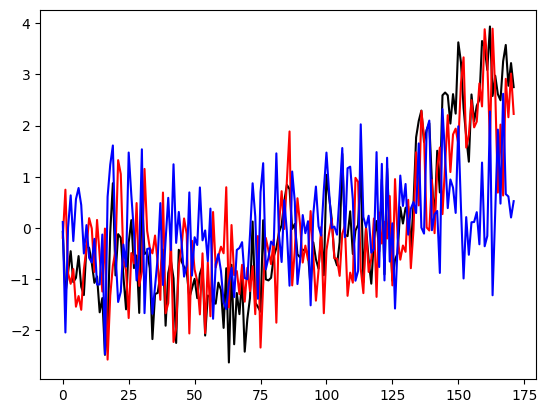

In [46]:
idx = 17
start = idx*172
end = start+172

plt.plot(ArcticTASTs_all_ensembles_MR[start:end], color='black')
plt.plot(tas_thermodynamically_induced[start:end], color='red')
plt.plot(tas_dynamically_induced[start:end], color='blue')

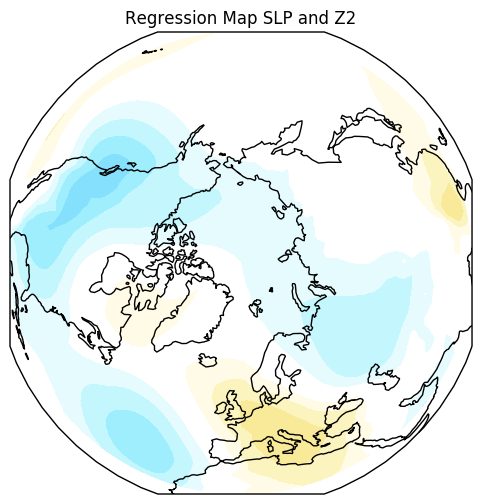

In [40]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap

def regression_maps(slp_djf_std, z_ts):
    # detrend SLP
    slp_detrended = []
    for lat in range(np.shape(slp_djf_std)[1]):
        lat_line = []
        for lon in range(np.shape(slp_djf_std)[2]):
            slp_djf_std_ts = slp_djf_std[:,lat,lon]
            slp_djf_std_regression = stats.pearsonr(slp_djf_std_ts, z_ts)[0]
            #X_regression = slp_djf_std_regression[1] + slp_djf_std_regression[0]*decades
            #X_detrended_ts = slp_djf_std_ts - X_regression
            #Z_slp_regression = stats.linregress(x=z_ts, y=X_detrended_ts)[0]
            lat_line.append(slp_djf_std_regression)
        slp_detrended.append(lat_line)
    return(slp_detrended)

# find correlation maps of detrended SLP with PLS regression components
regression_maps_with_Zs = []
for z in Zs_tas:
    regression_map_NH = regression_maps(WinterPSLMaps_all_ensembles_NH_MR, z)
    regression_maps_with_Zs.append(regression_map_NH)
regression_maps_with_Zs = np.array(regression_maps_with_Zs)

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#Plotting is below
lat_bins = np.linspace(20, 90., 28)
lon_bins = np.linspace(0, 360, 144)

lim = np.linspace(-1, 1, 21)
subplot_kw = dict(projection=ccrs.Orthographic(central_longitude=0, central_latitude=90))
fig, ax = plt.subplots(1, 1, figsize=(7, 6), subplot_kw=subplot_kw)
####################################################################################
ax.coastlines()
#ax.set_extent([ -20.0, 90.0])
ax.set_title('Regression Map SLP and Z2')
map_cyclic, lon = add_cyclic_point(regression_maps_with_Zs[3], coord=lon_bins)
im = ax.contourf(lon, lat_bins, map_cyclic, 20, levels=lim,
                 transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)

# below is an SKlearn based PLS fit, gets very close to what we have above. 

In [26]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold

# reshape data so that we treat all ensemble members as one big chain of data
ArcticTASTs_train = np.reshape(ArcticTASTs, (100*172))
WinterPSLMaps_train = np.reshape(WinterPSLMaps, (100*172,72,144))

# only need PSL data above 20N, also standardize data
WinterPSLMaps_all_ensembles_NH = WinterPSLMaps_train[:,44:,:]
WinterPSLMaps_all_ensembles_NH_MR = WinterPSLMaps_all_ensembles_NH - np.nanmean(WinterPSLMaps_all_ensembles_NH, axis=0)
WinterPSLMaps_all_ensembles_NH_stdzd = WinterPSLMaps_all_ensembles_NH_MR/np.nanstd(WinterPSLMaps_all_ensembles_NH_MR, axis=0)
WinterPSLMaps_all_ensembles_NH_stdzd_reshaped = np.reshape(WinterPSLMaps_all_ensembles_NH_stdzd, (17200,28*144))

PSL_weights = np.cos(np.deg2rad(data_1851_2023.lat[44:].values))

# standardize Arctic TAS data
ArcticTASTs_all_ensembles_MR = ArcticTASTs_train - np.nanmean(ArcticTASTs_train, axis=0)
ArcticTASTs_all_ensembles_stdzd = ArcticTASTs_all_ensembles_MR/np.nanstd(ArcticTASTs_all_ensembles_MR, axis=0)

# dynamic adjustment
X = WinterPSLMaps_all_ensembles_NH_stdzd_reshaped
Y = ArcticTASTs_all_ensembles_MR

pls = PLSRegression(scale=False)

cv = KFold(n_splits=5, shuffle=True)

# perform cross-validation for each number of components
n_components = [2,3,4,5,6]
for n in n_components:
    pls.n_components = n
    # calculate cross-validation score using R^2
    score = cross_val_score(pls, X, Y, cv=cv, scoring='r2').mean()
    print(score)

0.19187313781718776
0.2871334737281933
0.5195278515802865
0.5725087319725511
0.6156569919313929
